# Introduction

Here I'm testing the A2C on the "real-world" nyc graph. That is, I place the empirical trips on the manhattan street network, at the empirical times

In [1]:
import funcs as f
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from agent_with_baseline import Agent
from agent_taxi import PolicyCab
import real_world_nyc_environment as t
from keras.utils import to_categorical

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

%matplotlib inline



#Load in data
G = t.get_subgraph()  #start with a subgraph
#trip_data = t.get_tripdata(G,18,18) #monday, the 18th of jan
trip_data = np.loadtxt('data/trip_data_nyc_day_18.txt')
#env = Env(G,state_zero)

#Environment parameters
delta = 30  #trips wait 30 deci-seconds = 5 minutes before disappearing
time_per_episode = 5*360   #one day

state_zero = np.random.choice(G.nodes())
env = t.Env(G,trip_data,state_zero)

/home/kokeeffe/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Model cab

In [2]:
trip_probs = t.find_trip_probs(G,trip_data)
p = np.array(trip_probs.values())  #trip probs
optimal_policy = t.find_optimal_policy(p,G)

In [15]:
#Instantiate
np.random.seed(0)
state_zero = np.random.choice(G.nodes())
env = t.Env(G,trip_data,state_zero)
env.delta = delta
model_cab = t.Modelcab(optimal_policy)


# Main 
state = state_zero
Return = 0  # sum of rewards
while env.active_time <= time_per_episode:
    action = model_cab.act(state)
    next_state, reward = env.step_modelcab(action)  #different step functions for these cabs
    state = next_state
    Return += reward
tau_optimal = 1.0*env.idle_time / env.active_time
print 'rel idle time = ' + str(tau_optimal)

rel idle time = 0.073224043715847


### Greedy cab

In [16]:
greedy_policy = t.find_greedy_policy(trip_probs,G)

#Instantiate
np.random.seed(0)
state_zero = np.random.choice(G.nodes())
env = t.Env(G,trip_data,state_zero)
env.delta = delta
greedy_cab = t.Modelcab(greedy_policy)


# Main 
state = state_zero
while env.active_time <= time_per_episode:
    action = greedy_cab.act(state)
    next_state, reward = env.step_modelcab(action)
    state = next_state
tau_greedy = 1.0*env.idle_time / env.active_time
print 'rel idle time = ' + str(tau_greedy)

rel idle time = 0.21026490066225165


### RL agent

(episode, tau, score) = (50, 0.15178082191780823, -10535)
(episode, tau, score) = (100, 0.1447587354409318, -4581)
(episode, tau, score) = (150, 0.1772853185595568, -1280)
(episode, tau, score) = (200, 0.22234513274336284, 1817)
(episode, tau, score) = (250, 0.16, 3214)
(episode, tau, score) = (300, 0.6866666666666666, 164)
(episode, tau, score) = (350, 0.31336898395721924, 2115)
(episode, tau, score) = (400, 0.32390460343871325, 2216)
(episode, tau, score) = (450, 0.25694066412629285, 3128)
(episode, tau, score) = (500, 0.20683949255377826, 2825)
(episode, tau, score) = (550, 0.29453943739658023, 2766)
(episode, tau, score) = (600, 0.19824272377814386, 2839)
(episode, tau, score) = (650, 0.20609418282548475, 3129)
(episode, tau, score) = (700, 0.16752843846949328, 2977)
(episode, tau, score) = (750, 0.21666666666666667, 3010)
(episode, tau, score) = (800, 0.2910488742449204, 1773)
(episode, tau, score) = (850, 0.2620879120879121, 2324)
(episode, tau, score) = (900, 0.2185612300933553,

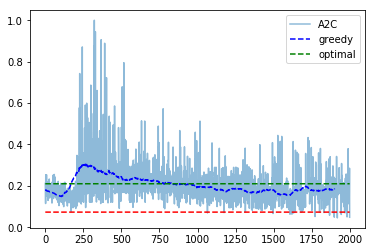

In [18]:
#Environment
state_zero_scalar = np.random.choice(G.nodes())
env = t.Env(G,trip_data,state_zero_scalar)
state_zero = env.convert(state_zero_scalar)  #convert to 1-hot vector
env.delta = delta
num_states = env.num_states
num_actions = env.num_actions
env.illegal_move_penalty = -100


#Agent
lr = 0.01
gamma = 0.1
agent = Agent(num_states, num_actions, lr, gamma)
agent.memory_size = 1000

#Train
EPISODES = 2000
scores = []
for e in range(1,EPISODES+1):
    state = state_zero 
    state = np.reshape(state, [1, num_states])  #convert to tensor for keras
    reward_sum = 0
    while env.active_time < time_per_episode:
        
        # env.render()
        action = agent.act(state)
        next_state_scalar, reward = env.step(action)
        next_state = env.convert(next_state_scalar)    #convert to 1-hot vec
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])  #convert to tensor for keras
        agent.remember(state[0], action, 1.0*reward)
        state = next_state
    
    #Learn & print results
    agent.train_models()
    tau = env.find_tau()
    scores.append(tau)
    env.reset(state_zero_scalar,trip_data)
    if e % 50 == 0:
        print '(episode, tau, score) = ' + str((e,tau,reward_sum))

        
plt.plot(scores,alpha=0.5)
plt.plot(running_mean(scores,100),'b--')  #num windows
plt.plot([tau_greedy for i in scores],'g--')
plt.plot([tau_optimal for i in scores],'r--')
plt.legend(['A2C','greedy','optimal'])
#np.savetxt('stats/scores_lunar_landing.txt',scores)

1. Note to self -- I should change the reward to $\tau$ directly
2. I'm not sure if doing the illegal moves this was is wise
3. Dont forget, this will probably overfit.

In [19]:
policy = {}
for state_scalar in list(G.nodes()):
    state_vec = np.reshape(env.convert(state_scalar),(1,num_states))
    action_probs = agent.actor.model.predict(state_vec)[0]
    print action_probs
    best_action = np.argmax(action_probs)
    neighbours = G[state_scalar].keys()
    policy[state_scalar] = neighbours[best_action]

[9.8601794e-01 1.3961648e-02 4.1175426e-06 1.6239943e-05]
[8.60829532e-01 1.39064461e-01 1.27436115e-05 9.32664043e-05]
[9.9406648e-01 5.9221527e-03 2.8387669e-06 8.5257561e-06]
[8.5111982e-01 1.4863330e-01 3.3956931e-05 2.1291157e-04]
[4.0937558e-01 5.8858317e-01 2.3346567e-04 1.8078745e-03]


IndexError: list index out of range

Looks like my guy is doing slightly BETTER. Huh. I wonder how differnt their policies are.

(episode, tau, score) = (50, 0.17769272826681246, -11080)
(episode, tau, score) = (100, 0.138635142396561, -1507)
(episode, tau, score) = (150, 0.18253968253968253, 1375)
(episode, tau, score) = (200, 0.2384914032168608, 2775)
(episode, tau, score) = (250, 0.21975040694519804, 2400)
(episode, tau, score) = (300, 0.18898071625344354, 3558)
(episode, tau, score) = (350, 0.1605960264900662, 3311)
(episode, tau, score) = (400, 0.1912479740680713, 2647)
(episode, tau, score) = (450, 0.19536423841059603, 3147)
(episode, tau, score) = (500, 0.1054897739504844, 4106)
(episode, tau, score) = (550, 0.1626278944534195, 2403)
(episode, tau, score) = (600, 0.17358078602620086, 3284)
(episode, tau, score) = (650, 0.1505257332595462, 3629)
(episode, tau, score) = (700, 0.3372222222222222, 1498)
(episode, tau, score) = (750, 0.10460021905805038, 3309)
(episode, tau, score) = (800, 0.10231023102310231, 3515)
(episode, tau, score) = (850, 0.10883977900552486, 2805)
(episode, tau, score) = (900, 0.129967

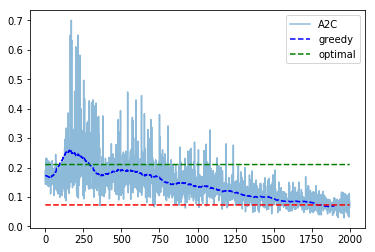

In [21]:
#Environment
state_zero_scalar = np.random.choice(G.nodes())
env = t.Env(G,trip_data,state_zero_scalar)
state_zero = env.convert(state_zero_scalar)  #convert to 1-hot vector
env.delta = delta
num_states = env.num_states
num_actions = env.num_actions
env.illegal_move_penalty = -100


#Agent
lr = 0.01
gamma = 0.9
agent = Agent(num_states, num_actions, lr, gamma)
agent.memory_size = 1000

#Train
EPISODES = 2000
scores = []
for e in range(1,EPISODES+1):
    state = state_zero 
    state = np.reshape(state, [1, num_states])  #convert to tensor for keras
    reward_sum = 0
    while env.active_time < time_per_episode:
        
        # env.render()
        action = agent.act(state)
        next_state_scalar, reward = env.step(action)
        next_state = env.convert(next_state_scalar)    #convert to 1-hot vec
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])  #convert to tensor for keras
        agent.remember(state[0], action, 1.0*reward)
        state = next_state
    
    #Learn & print results
    agent.train_models()
    tau = env.find_tau()
    scores.append(tau)
    env.reset(state_zero_scalar,trip_data)
    if e % 50 == 0:
        print '(episode, tau, score) = ' + str((e,tau,reward_sum))

        
plt.plot(scores,alpha=0.5)
plt.plot(running_mean(scores,100),'b--')  #num windows
plt.plot([tau_greedy for i in scores],'g--')
plt.plot([tau_optimal for i in scores],'r--')
plt.legend(['A2C','greedy','optimal'])
#np.savetxt('stats/scores_lunar_landing.txt',scores)

Looks good! I'll continute the learning below.

(episode, tau, score) = (50, 0.06263858093126386, 4787)
(episode, tau, score) = (100, 0.04837822979659153, 4812)
(episode, tau, score) = (150, 0.05204872646733112, 4406)
(episode, tau, score) = (200, 0.051790633608815424, 4106)
(episode, tau, score) = (250, 0.03397260273972603, 4038)
(episode, tau, score) = (300, 0.044986449864498644, 4017)
(episode, tau, score) = (350, 0.06400437636761488, 4283)
(episode, tau, score) = (400, 0.05175202156334232, 4204)
(episode, tau, score) = (450, 0.05421686746987952, 4501)
(episode, tau, score) = (500, 0.03055100927441353, 4044)
(episode, tau, score) = (550, 0.039400665926748055, 3829)
(episode, tau, score) = (600, 0.03503184713375796, 4034)
(episode, tau, score) = (650, 0.027129679869777535, 3950)
(episode, tau, score) = (700, 0.03895410885805763, 4327)
(episode, tau, score) = (750, 0.04455445544554455, 4519)
(episode, tau, score) = (800, 0.06451612903225806, 4183)
(episode, tau, score) = (850, 0.051047823750671684, 4505)
(episode, tau, score) = (90

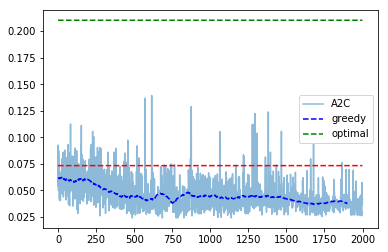

In [22]:
#Train
EPISODES = 2000
scores = []
for e in range(1,EPISODES+1):
    state = state_zero 
    state = np.reshape(state, [1, num_states])  #convert to tensor for keras
    reward_sum = 0
    while env.active_time < time_per_episode:
        
        # env.render()
        action = agent.act(state)
        next_state_scalar, reward = env.step(action)
        next_state = env.convert(next_state_scalar)    #convert to 1-hot vec
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])  #convert to tensor for keras
        agent.remember(state[0], action, 1.0*reward)
        state = next_state
    
    #Learn & print results
    agent.train_models()
    tau = env.find_tau()
    scores.append(tau)
    env.reset(state_zero_scalar,trip_data)
    if e % 50 == 0:
        print '(episode, tau, score) = ' + str((e,tau,reward_sum))

        
plt.plot(scores,alpha=0.5)
plt.plot(running_mean(scores,100),'b--')  #num windows
plt.plot([tau_greedy for i in scores],'g--')
plt.plot([tau_optimal for i in scores],'r--')
plt.legend(['A2C','greedy','optimal'])
#np.savetxt('stats/scores_lunar_landing.txt',scores

Great! Remember -- this is all for 5  hours. Now I'll scale up to full 24 hours

### Roughwork -- change delta

In [5]:
#Environment
delta = 1
state_zero_scalar = np.random.choice(G.nodes())
env = t.Env(G,trip_data,state_zero_scalar)
state_zero = env.convert(state_zero_scalar)  #convert to 1-hot vector
env.delta = delta
num_states = env.num_states
num_actions = env.num_actions
env.illegal_move_penalty = -100


#Agent
lr = 0.01
gamma = 0.9
agent = Agent(num_states, num_actions, lr, gamma)
agent.memory_size = 1000

#Train
EPISODES = 4000
scores = []
for e in range(1,EPISODES+1):
    state = state_zero 
    state = np.reshape(state, [1, num_states])  #convert to tensor for keras
    reward_sum = 0
    while env.active_time < time_per_episode:
        
        # env.render()
        action = agent.act(state)
        next_state_scalar, reward = env.step(action)
        next_state = env.convert(next_state_scalar)    #convert to 1-hot vec
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])  #convert to tensor for keras
        agent.remember(state[0], action, 1.0*reward)
        state = next_state
    
    #Learn & print results
    agent.train_models()
    tau = env.find_tau()
    scores.append(tau)
    env.reset(state_zero_scalar,trip_data)
    if e % 50 == 0:
        print '(episode, tau, score) = ' + str((e,tau,reward_sum))

        
plt.plot(scores,alpha=0.5)
plt.plot(running_mean(scores,100),'b--')  #num windows
plt.plot([tau_greedy for i in scores],'g--')
plt.plot([tau_optimal for i in scores],'r--')
plt.legend(['A2C','greedy','optimal'])
#np.savetxt('stats/scores_lunar_landing.txt',scores)

(episode, tau, score) = (50, 0.4767504008551577, -34626)
(episode, tau, score) = (100, 0.3748621830209482, -6701)
(episode, tau, score) = (150, 0.47799779977997797, -1642)
(episode, tau, score) = (200, 0.975, -2941)
(episode, tau, score) = (250, 0.4888888888888889, 1521)
(episode, tau, score) = (300, 0.4109211252068395, 1955)
(episode, tau, score) = (350, 0.9866666666666667, -1775)


KeyboardInterrupt: 

In [9]:
#Load in data
G = t.get_subgraph()  #start with a subgraph
#trip_data = t.get_tripdata(G,18,18) #monday, the 18th of jan
trip_data = np.loadtxt('data/trip_data_nyc_day_18.txt')
#env = Env(G,state_zero)

#Environment parameters
delta = 30  #trips wait 30 deci-seconds = 5 minutes before disappearing
time_per_episode = 5*360   

state_zero = np.random.choice(G.nodes())
env = t.Env(G,trip_data,state_zero)

In [15]:
trip_probs = t.find_trip_probs(G,trip_data)
#p = np.array(trip_probs.values())  #trip probs
p *= 30
optimal_policy = t.find_optimal_policy(p,G)

ValueError: min() arg is an empty sequence

In [17]:
G = nx.DiGraph(G)
A = nx.adjacency_matrix(G)
A = np.array(A.todense())
nodes = [node for node in G.nodes()]

x0 = np.random.rand(len(p))
x = t.find_optimal_waiting_times(x0,p,A)

policy = (x,G,nodes)

ValueError: min() arg is an empty sequence

In [63]:
t.rhs(x0,p,A)

array([-2.38071779e-01,  4.76259623e-01,  6.50474964e-01,  5.46346838e-01,
        1.18869171e+00,  7.99977052e-01,  1.47691499e+00, -6.38287415e+00,
        1.67000513e-01, -1.85702399e+00,  9.47755554e-01, -2.17997991e+00,
       -1.86806104e+00, -3.41685347e-01, -8.25174228e-01, -1.73100825e+00,
       -8.21180826e+00, -2.27556568e-02, -6.49006935e+00, -7.28470352e+00,
       -1.58326942e+00, -7.71606859e+00, -8.47407392e+00,  1.68084752e+00,
        6.47806905e-01, -6.68075172e+00, -1.38254582e+00, -4.46459246e+00,
       -6.39694861e+00,  5.59392979e-01,  6.80920513e-01, -1.34633984e+00,
       -6.14784139e+00, -1.79803054e+00, -1.05810500e+00, -1.19847017e+01,
        6.02378321e-01, -2.30239319e+00,  9.35436781e-01, -4.16530590e-01,
        2.47760514e-01,  1.00350975e+00, -6.81351373e-02,  9.80111405e-01,
       -7.59620969e+00,  9.25626954e-01, -3.80102172e+00,  4.97141680e-01,
       -6.14785401e-01, -1.55193578e+00, -1.43595849e-02,  9.68459273e-01,
        3.26521445e-01, -

575 575


ValueError: min() arg is an empty sequence

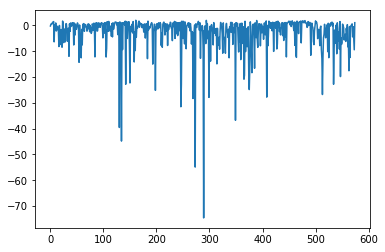

In [55]:
x = x0
tolerance = 0.05

err = 1
xold = x
while err > tolerance:
    xnew = t.rhs(xold,p,A)
    err = (xnew - xold).max()
    xold = xnew
    print len(xold), len(xnew)

In [52]:
b[9]

array([ -0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,   0.        ,   0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,  -0.        ,
         0.        ,   0.        ,  -0.        ,   0.        ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
        -0.        ,  -0.        ,  -0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        ,   0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,   0.        ,   0.        ,   0.  